In [458]:
# basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, plot_confusion_matrix, plot_roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# statsmodels
import statsmodels.api as sm

# helpers
from boruta import BorutaPy

# notebbok style
import warnings
warnings.filterwarnings("ignore")
sns.set(style="darkgrid")

### Read in data, encode target variable

Target: {0 : benign; 1 : malignant / cancerous}

In [57]:
data = pd.read_csv("breast-cancer-wisconsin.data", header = None, names = ['id', 'clump_thickness', 'cell_size_uniformity', 'cell_shape_uniformity', 'marginal_adhesion', 'single_epithelial_cell_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class'])
data['class'] = data['class'].map({2: 'benign', 4: 'malignant'})
data.head()

,id,clump_thickness,cell_size_uniformity,cell_shape_uniformity,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,benign
1,1002945,5,4,4,5,7,10,3,2,1,benign
2,1015425,3,1,1,1,2,2,3,1,1,benign
3,1016277,6,8,8,1,3,4,3,7,1,benign
4,1017023,4,1,1,3,2,1,3,1,1,benign


In [58]:
encoder = LabelEncoder()
encoder.fit(data['class'])

data['class'] = encoder.transform(data['class'])

data.rename(columns = {'class': 'malignant'}, inplace = True)

data.head()

,id,clump_thickness,cell_size_uniformity,cell_shape_uniformity,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,malignant
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


### Explore dataset

#### Target variable

In [59]:
target_freq = pd.concat([data['malignant'].value_counts(), data['malignant'].value_counts(normalize=True) * 100], axis = 1, keys = ['#', '%'])
target_freq

,#,%
0,458,65.522175
1,241,34.477825


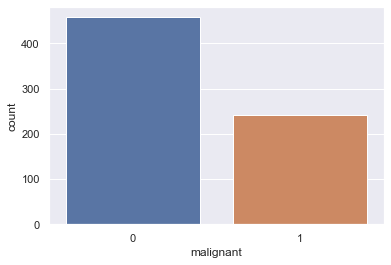

In [60]:
sns.countplot(x = "malignant", data = data)

#### X variables

In [61]:
data.dtypes

id                              int64
clump_thickness                 int64
cell_size_uniformity            int64
cell_shape_uniformity           int64
marginal_adhesion               int64
single_epithelial_cell_size     int64
bare_nuclei                    object
bland_chromatin                 int64
normal_nucleoli                 int64
mitoses                         int64
malignant                       int32
dtype: object

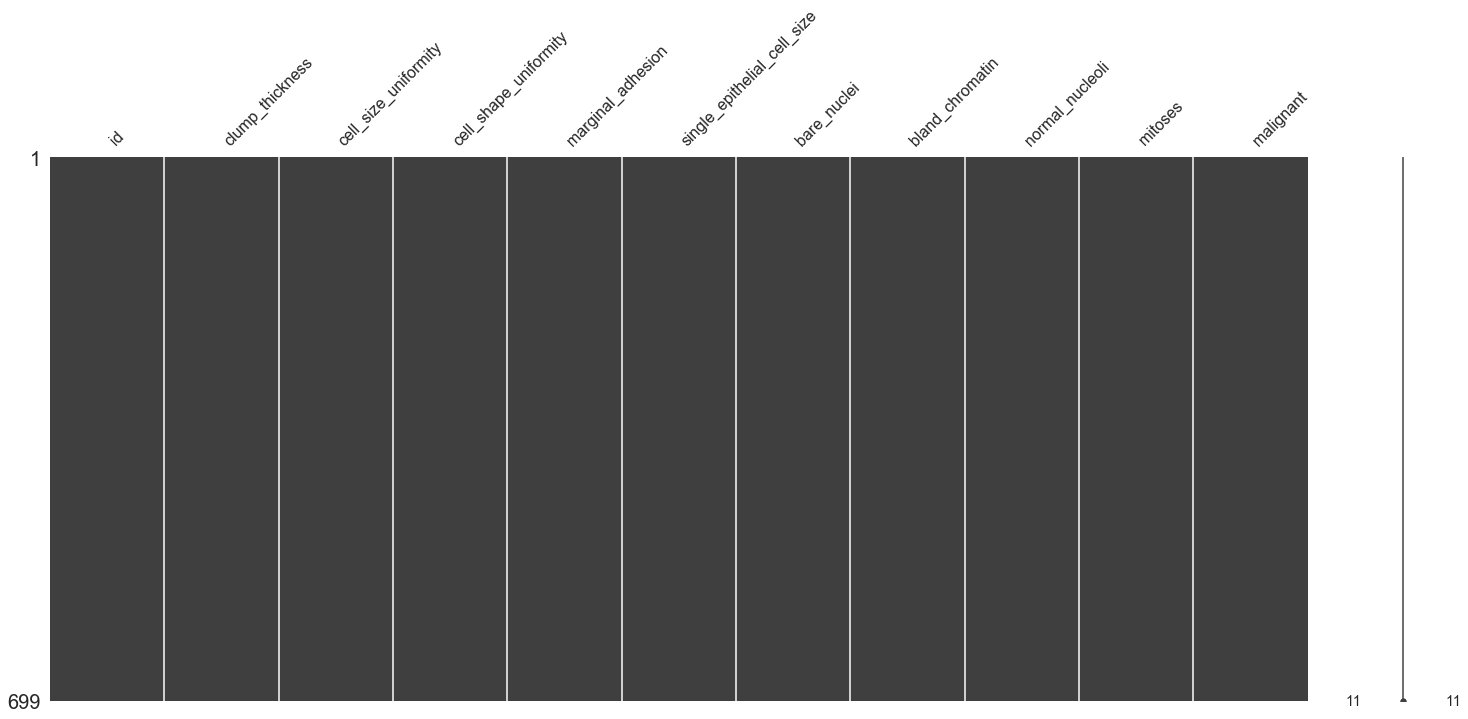

In [62]:
msno.matrix(data)

In [63]:
data.describe(include = ['O'])

,bare_nuclei
count,699
unique,11
top,1
freq,402


In [64]:
data['bare_nuclei'].value_counts()

1     402
10    132
5      30
2      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: bare_nuclei, dtype: int64

In [65]:
data = data[data['bare_nuclei'] != '?']
data['bare_nuclei'] = data['bare_nuclei'].astype('int')

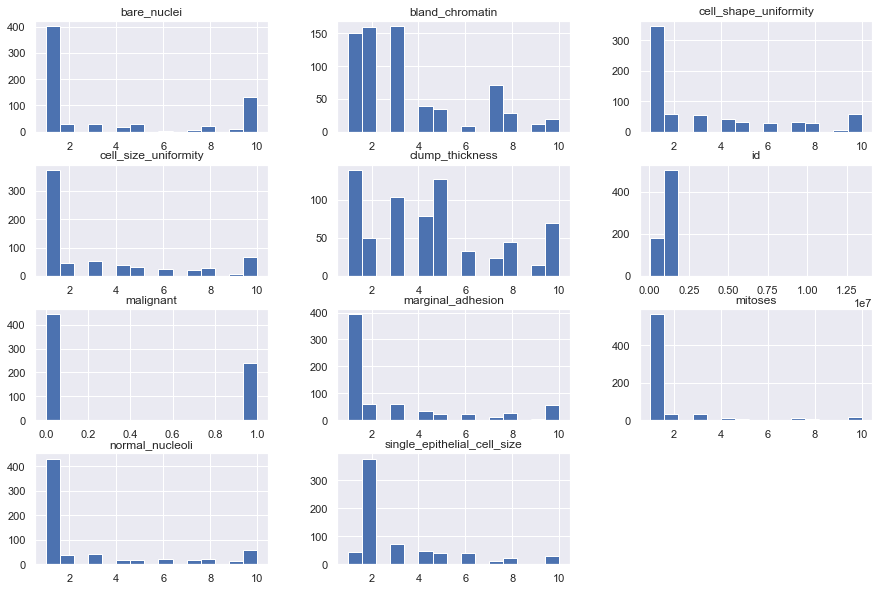

In [66]:
data.hist(bins = 15, figsize = (15, 10))
plt.show()

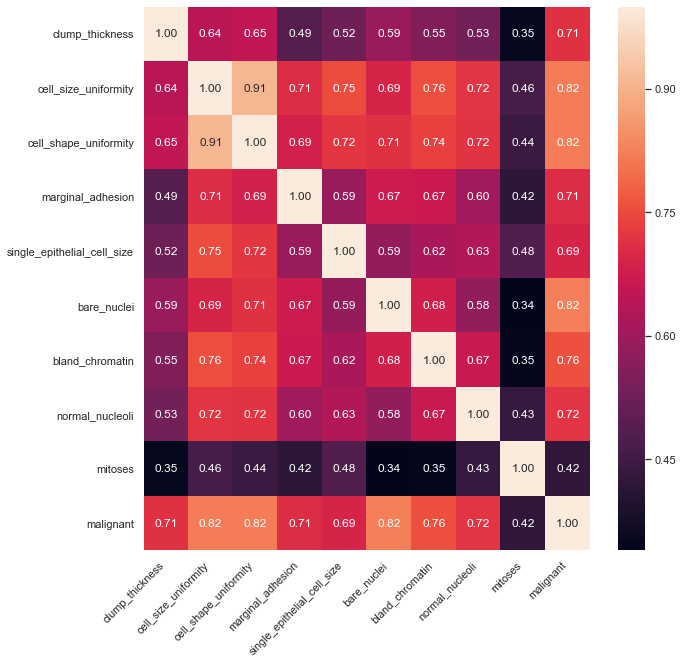

In [67]:
correlations = data.drop('id', 1).corr()

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(correlations, annot = True, fmt = ".2f")

ax.set_xticklabels(data.drop('id', 1).columns, rotation=45, horizontalalignment='right')
ax.set_yticklabels(data.drop('id', 1).columns)

plt.show()

cell_size_uniformity & cell_shape_uniformity correlate high (+0.9). Which one to drop and keep? Transform them into 1 maybe? i'll run Boruta to see if either one is insignificant.

In [72]:
forest = RandomForestClassifier(max_depth = 5)
boruta = BorutaPy(estimator = forest, n_estimators = 'auto', max_iter = 100)
boruta.fit(np.array(data.drop(['id', 'malignant'], 1)), np.array(data['malignant']))

BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                          class_weight=None, criterion='gini',
                                          max_depth=5, max_features='auto',
                                          max_leaf_nodes=None, max_samples=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=84, n_jobs=None,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x1646A869990,
                                          verbose=0, warm_start=False),
         max_iter=100, n_estimators='aut

In [80]:
to_keep = data.drop(['id', 'malignant'], 1).columns[boruta.support_].to_list()

print('Boruta suggests keeping', len(to_keep), 'features out of 9:', to_keep)

Boruta suggests keeping 9 features out of 9: ['clump_thickness', 'cell_size_uniformity', 'cell_shape_uniformity', 'marginal_adhesion', 'single_epithelial_cell_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses']


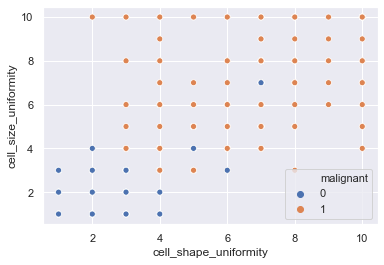

In [82]:
sns.scatterplot(data['cell_shape_uniformity'], data['cell_size_uniformity'], hue = data['malignant'])
plt.show()

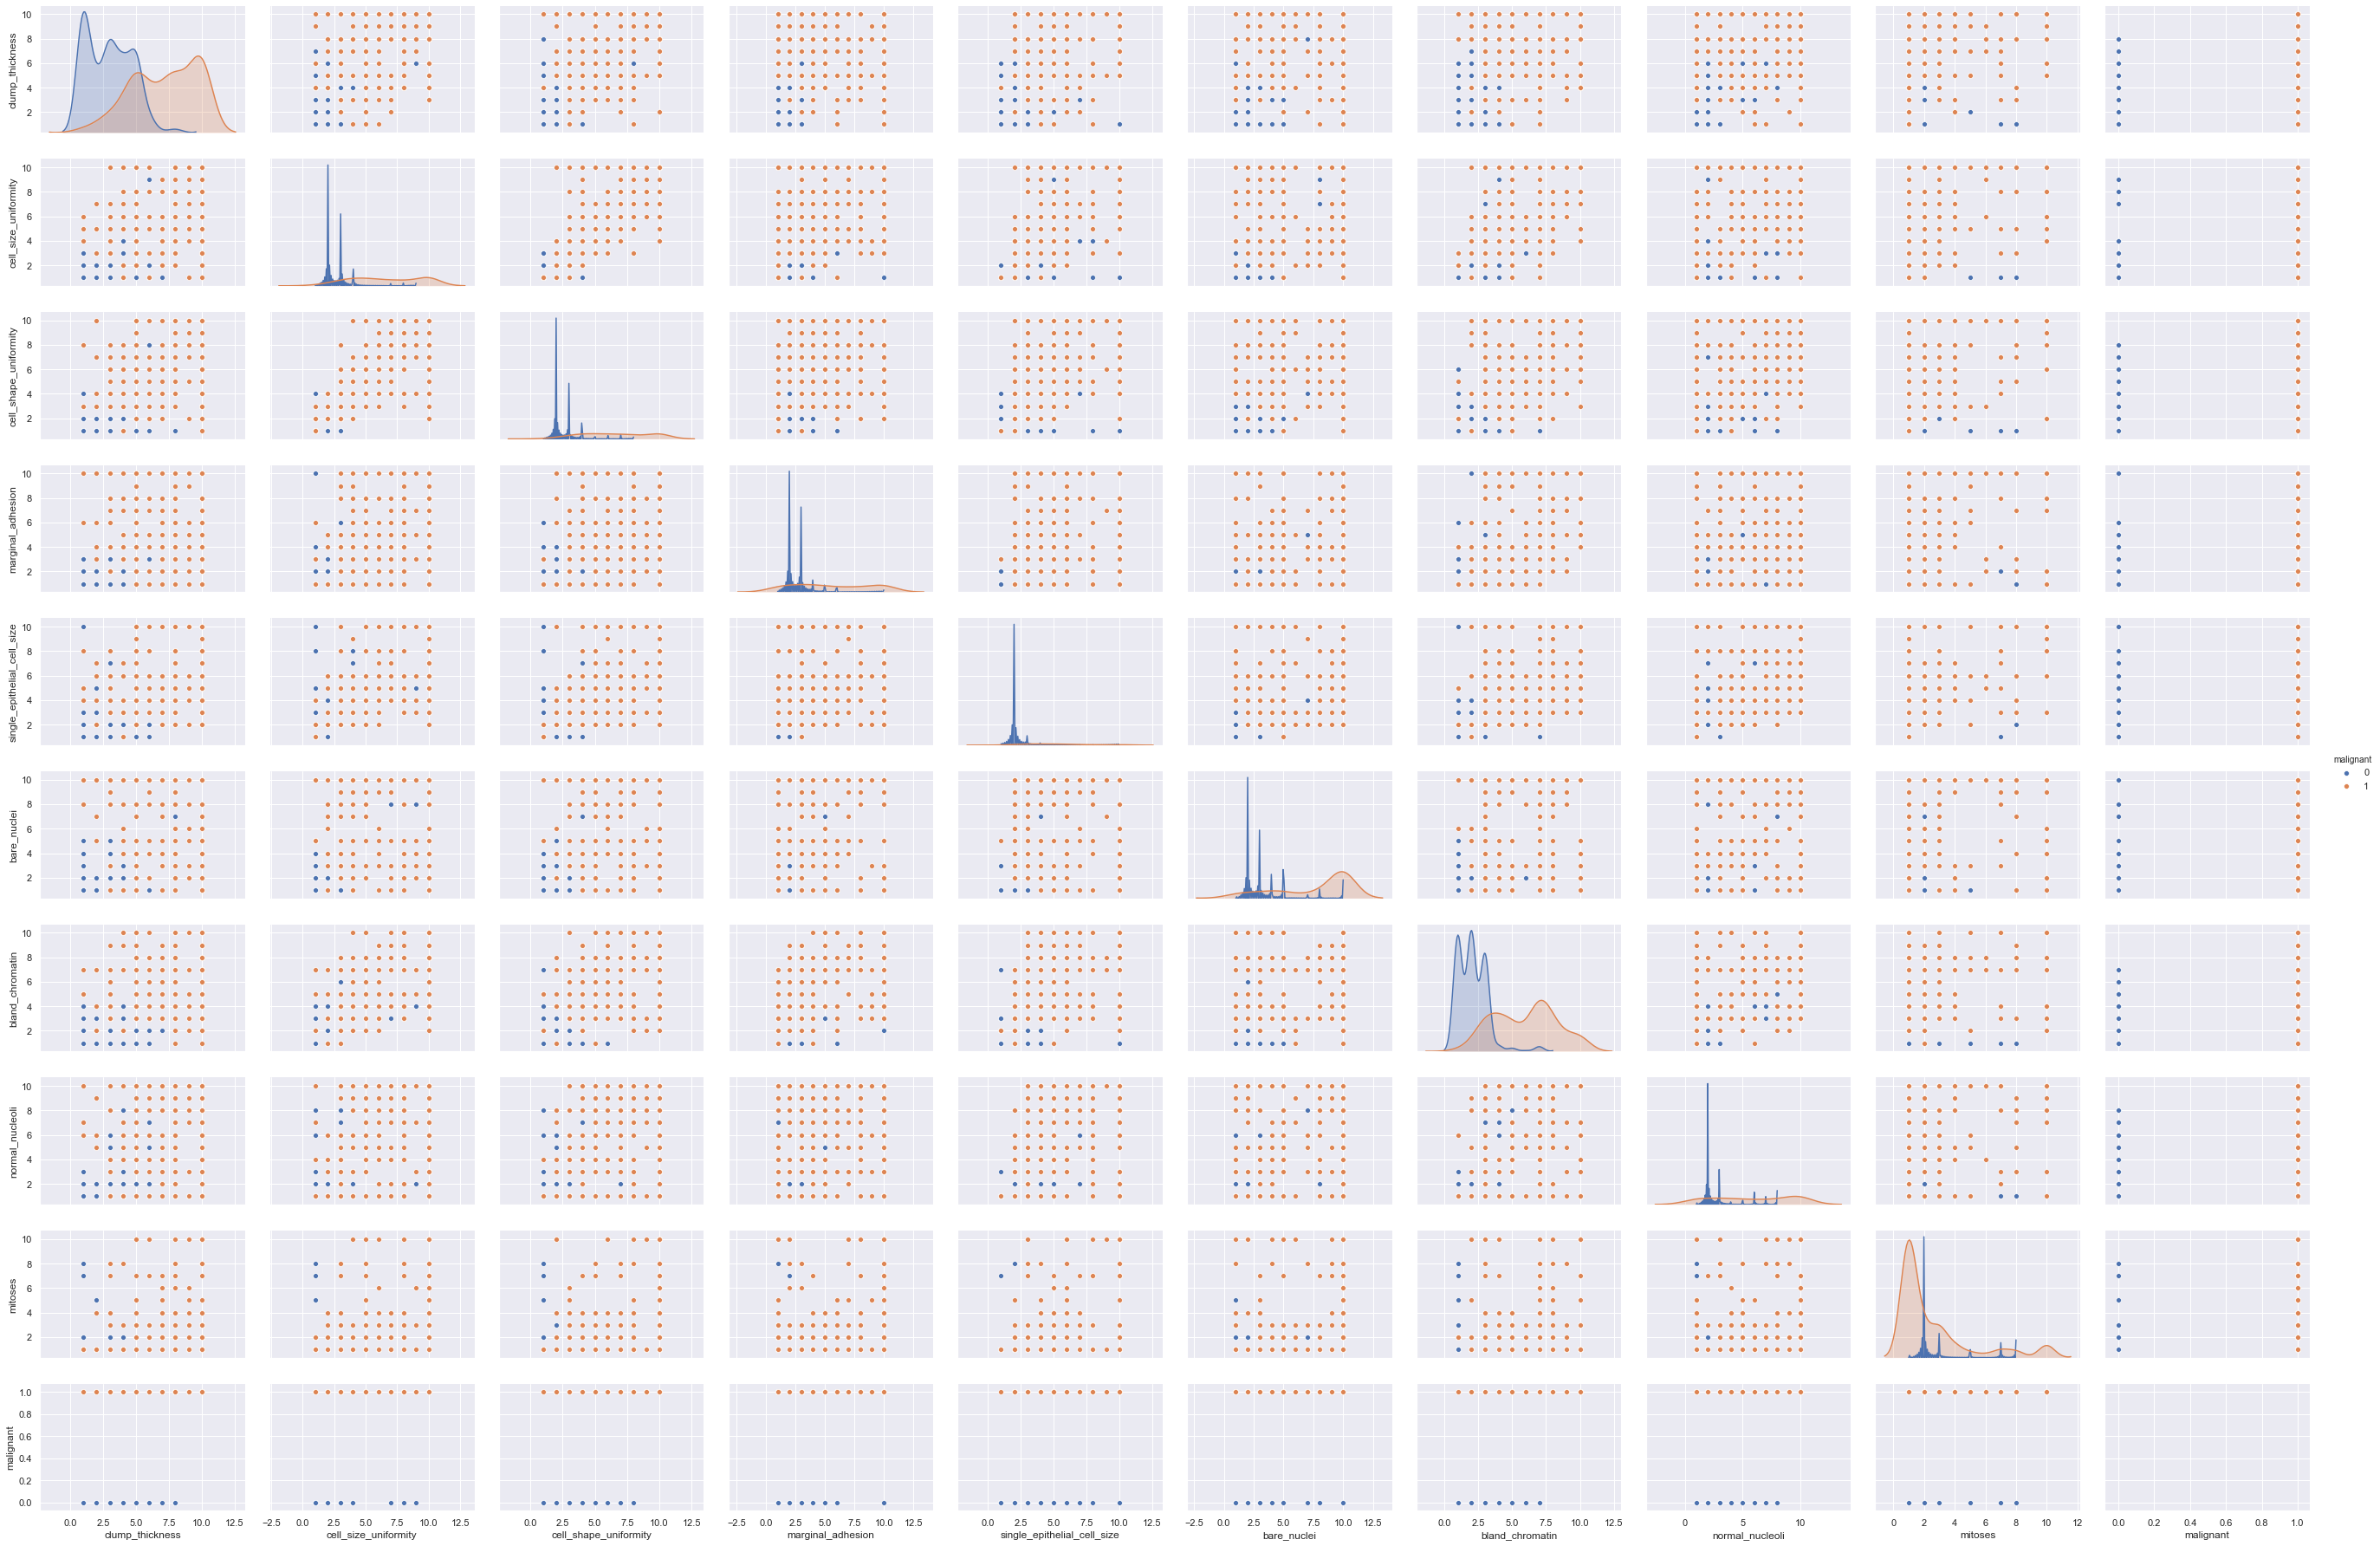

In [84]:
sns.pairplot(data.drop('id', 1), hue = 'malignant', aspect=1.5)
plt.show()

Dropping cell_size for now

In [85]:
data.drop('cell_size_uniformity', 1, inplace = True)

### Preprocess data (scale, split)

In [101]:
X = data.copy().drop(['id', 'malignant'], 1)
y = data['malignant']

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state = 20202020)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(512, 8) (171, 8) (512,) (171,)


In [105]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Apply logistic regression

In [204]:
logit = LogisticRegression(penalty = 'none')
logit.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [205]:
pred_prob = pd.DataFrame(logit.predict_proba(X_test_scaled), columns = ['prediction_for_class_0', 'prediction_for_class_1'])
pred_class = pd.DataFrame(logit.predict(X_test_scaled), columns = ['predicted_class'])
act_class = pd.DataFrame(np.array(y_test), columns = ['actual_class'])

pd.concat([pred_prob, pred_class, act_class], 1).head()

,prediction_for_class_0,prediction_for_class_1,predicted_class,actual_class
0,0.023413,0.976587,1,1
1,0.997873,0.002127,0,0
2,0.998840,0.001160,0,0
3,0.978933,0.021067,0,0
4,0.982435,0.017565,0,0


In [206]:
print('Accuracy on test set: ', round(accuracy_score(y_test, logit.predict(X_test_scaled)), 3))
print('AUC on test set: ', round(roc_auc_score(y_test, logit.predict_proba(X_test_scaled)[:,1]), 3))
print('\n')
print(classification_report(y_test, logit.predict(X_test_scaled)))

Accuracy on test set:  0.965
AUC on test set:  0.996


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       111
           1       0.95      0.95      0.95        60

    accuracy                           0.96       171
   macro avg       0.96      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171



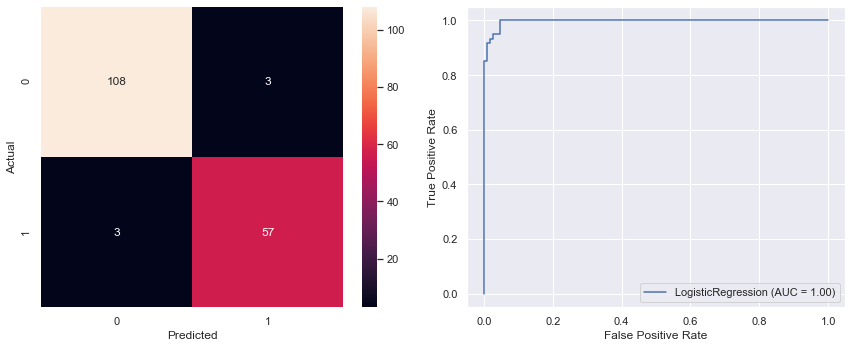

In [207]:
fig, axs = plt.subplots(ncols = 2, figsize=(12, 5))

confusion_matrix = pd.crosstab(y_test, logit.predict(X_test_scaled), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot = True, cmap = None, fmt='.0f', ax = axs[0])

plot_roc_curve(logit, X_test_scaled, y_test, ax = axs[1])

fig.tight_layout()
plt.show()

In [259]:
logit_coeff = pd.concat([pd.DataFrame(X_train.columns, columns = ['Feature']), 
           pd.DataFrame(np.transpose(logit.coef_), columns = ['Coefficient'])], 
          axis = 1)

logit_coeff

,Feature,Coefficient
0,clump_thickness,1.537763
1,cell_shape_uniformity,0.939045
2,marginal_adhesion,0.511741
3,single_epithelial_cell_size,0.717133
4,bare_nuclei,1.375577
5,bland_chromatin,1.213184
6,normal_nucleoli,0.434297
7,mitoses,0.963679


Coefficients are usually great, but in case of logit we need mfx (marginal effects). Let's re-apply the model via the statsmodels API and extract the marginal effects from there

In [254]:
X_train_scaled_for_sm = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_train_scaled_for_sm = sm.add_constant(X_train_scaled_for_sm)

y_train.reset_index(drop = True, inplace = True)

sm_model = sm.Logit(y_train, X_train_scaled_for_sm).fit()

sm_model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.074235
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
const,-1.1228,0.387,-2.899,0.004,-1.882,-0.364
clump_thickness,1.5378,0.460,3.342,0.001,0.636,2.440
cell_shape_uniformity,0.9391,0.660,1.422,0.155,-0.355,2.233
marginal_adhesion,0.5117,0.408,1.255,0.209,-0.287,1.311
single_epithelial_cell_size,0.7171,0.459,1.563,0.118,-0.182,1.616
bare_nuclei,1.3756,0.419,3.281,0.001,0.554,2.197
bland_chromatin,1.2132,0.508,2.389,0.017,0.218,2.209
normal_nucleoli,0.4342,0.392,1.106,0.269,-0.335,1.203
mitoses,0.9637,0.711,1.355,0.176,-0.431,2.358


In [258]:
sm_model.get_margeff().summary().tables[1]

,dy/dx,std err,z,P>|z|,[0.025,0.975]
clump_thickness,0.0292,0.009,3.207,0.001,0.011,0.047
cell_shape_uniformity,0.0178,0.012,1.444,0.149,-0.006,0.042
marginal_adhesion,0.0097,0.008,1.233,0.218,-0.006,0.025
single_epithelial_cell_size,0.0136,0.009,1.578,0.115,-0.003,0.031
bare_nuclei,0.0261,0.008,3.379,0.001,0.011,0.041
bland_chromatin,0.0230,0.010,2.348,0.019,0.004,0.042
normal_nucleoli,0.0082,0.007,1.106,0.269,-0.006,0.023
mitoses,0.0183,0.014,1.351,0.177,-0.008,0.045


Show features, coefficients and marginal effects in one table, enhance them with odds prob

In [283]:
marg_eff = pd.DataFrame(sm_model.get_margeff().summary().tables[1])[[0, 1]]
marg_eff.rename(columns = {0 : 'Feature', 1 : 'MFX'}, inplace = True)
marg_eff = marg_eff.iloc[1:]

In [370]:
marg_eff.reset_index(drop = True, inplace = True)
logit_coeff.reset_index(drop = True, inplace = True)

coeff_mfx = logit_coeff.join(marg_eff, rsuffix = 'a')
coeff_mfx.drop('Featurea', 1, inplace = True)
coeff_mfx['MFX'] = coeff_mfx['MFX'].astype('str').astype('float')

coeff_mfx.sort_values('MFX', ascending = False)

,Feature,Coefficient,MFX
0,clump_thickness,1.537763,0.0292
4,bare_nuclei,1.375577,0.0261
5,bland_chromatin,1.213184,0.0230
7,mitoses,0.963679,0.0183
1,cell_shape_uniformity,0.939045,0.0178
3,single_epithelial_cell_size,0.717133,0.0136
2,marginal_adhesion,0.511741,0.0097
6,normal_nucleoli,0.434297,0.0082


#### Try some visuals

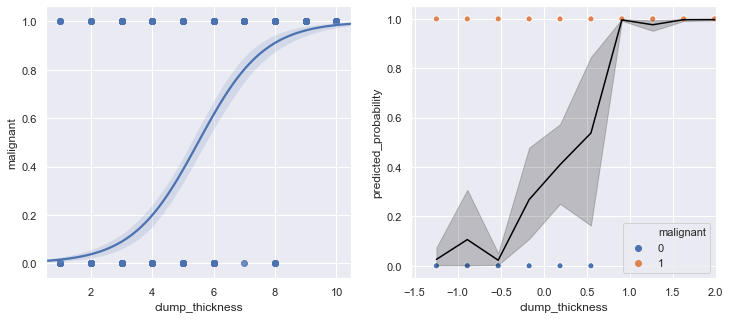

In [402]:
fig, axs = plt.subplots(ncols = 2, figsize=(12, 5))

sns.regplot(x = 'clump_thickness', y = 'malignant', data = data, logistic = True, ax = axs[0])

test_data = pd.concat([pd.DataFrame(X_test_scaled, columns = X_test.columns),
                       pd.DataFrame(logit.predict_proba(X_test_scaled)[:,1], columns = ['predicted_probability']),
                       pd.DataFrame(y_test)], 1)

sns.scatterplot(x = 'clump_thickness', y = 'malignant', hue = 'malignant', data = test_data, ax = axs[1])
sns.lineplot(x = 'clump_thickness', y = 'predicted_probability', data = test_data, c = 'black', ax = axs[1]).set(xlim=(None, 2))
plt.show()

##### Apply PCA to be able to visualize all features' relationship to class outcomes

In [406]:
pca = PCA(random_state = 20202020)
pca.fit(X_test_scaled)

comp = pd.DataFrame(pca.components_, columns = X_test.columns)
exp_var = pd.DataFrame(pca.explained_variance_ratio_ * 100, columns = ['Explained variance %'])

pca_results = pd.concat([exp_var, comp], 1)
pca_results

,Explained variance %,clump_thickness,cell_shape_uniformity,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses
0,65.767771,0.368064,0.394868,0.347541,0.328370,0.376070,0.394406,0.392783,0.169512
1,7.596942,0.508727,-0.049792,0.258625,-0.313259,0.430201,-0.152078,-0.581672,-0.164794
2,6.110469,0.681820,-0.003881,-0.486648,0.226975,-0.349773,-0.142457,-0.053561,0.318211
3,5.881721,-0.170215,0.190908,0.271716,-0.337066,-0.099620,-0.112393,-0.144812,0.838815
4,5.407563,-0.059953,0.101292,0.478781,0.542909,-0.473463,0.048893,-0.474189,-0.103692
5,3.648745,-0.228722,-0.029461,-0.436006,0.175973,0.289332,0.602711,-0.487314,0.203229
6,3.047863,0.223469,-0.074228,0.122655,-0.517017,-0.472785,0.643620,0.057953,-0.145152
7,2.538926,-0.077640,0.887976,-0.259415,-0.189439,-0.099133,-0.092151,-0.133613,-0.257130


In [413]:
pca_applied = pd.DataFrame(pca.transform(X_test_scaled))
pca_applied = pca_applied[[0, 1]].copy()
pca_applied.columns = ['PCA_1', 'PCA_2']

test_data_with_PCA = pd.concat([pd.DataFrame(X_test_scaled, columns = X_test.columns), pca_applied, y_test], 1)

test_data_with_PCA.head()

,clump_thickness,cell_shape_uniformity,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,PCA_1,PCA_2,malignant
0,-1.247161,1.593033,1.108770,0.777568,1.232199,1.445173,2.409163,-0.357001,2.743510,-1.661158,1
1,-0.528886,-0.741158,-0.629412,-0.552437,-0.703882,-1.011701,-0.600168,-0.357001,-1.833759,0.078747,0
2,-1.247161,-0.741158,-0.629412,-0.552437,-0.703882,-0.602222,-0.600168,-0.357001,-1.936629,-0.348931,0
3,0.189389,-0.741158,1.108770,-0.109102,-0.703882,-1.011701,-0.600168,-0.357001,-0.819721,0.754810,0
4,-0.528886,-0.407702,-0.281775,-0.552437,-0.703882,0.216736,-0.265798,-0.357001,-0.965433,-0.229262,0


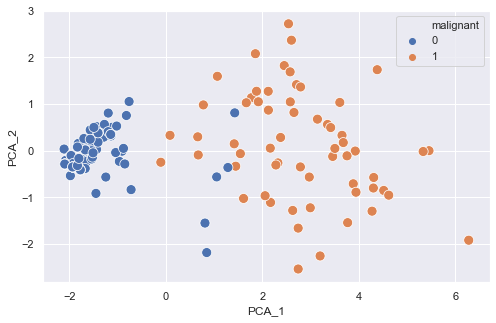

In [414]:
plt.figure(figsize = (8, 5))
sns.scatterplot('PCA_1', 'PCA_2', data = test_data_with_PCA, hue = 'malignant', s = 100)
plt.show()

The 1st PCA contains all features with a positive and similar weight. Benign cells are all closer to the negative end of the x axis, meaning on average the smallest values in any category are a good sign, as larger values tend to go together with the malignant class.

Positive coefficients and MFXs (all are > 0) of the logistic regression prove the above idea.

### Apply a RandomForest and compare variable importances with logit's marginal effects list

In [422]:
parameters = {'min_samples_split': [3, 5, 7],
              'max_depth': [5, 7, 9],
              'max_features' : [2, 3, 4]}

classifier = RandomForestClassifier(random_state = 20202020, n_estimators = 150)

tuner = GridSearchCV(classifier, parameters, verbose = 0, cv = 5, scoring = 'roc_auc')

tuner.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=150, n_jobs=None,
                                              oob_score=False,
                                              rando

In [423]:
tuner.best_params_

{'max_depth': 7, 'max_features': 2, 'min_samples_split': 5}

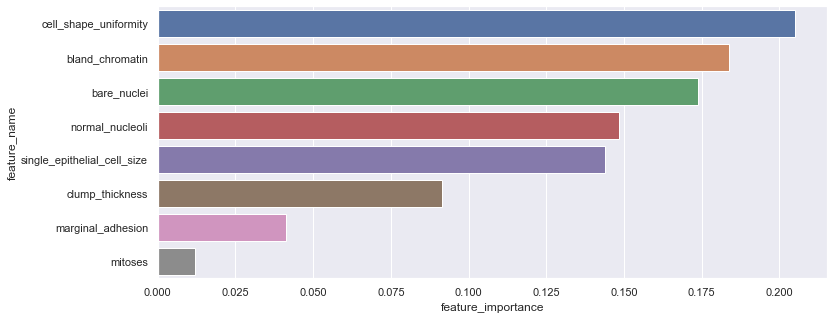

In [424]:
feature_importances = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(tuner.best_estimator_.feature_importances_)], 1)
feature_importances.columns = ['feature_name', 'feature_importance']
feature_importances = feature_importances.sort_values('feature_importance', ascending = False)

plt.figure(figsize = (12,5))
sns.barplot(y = feature_importances['feature_name'], x = feature_importances['feature_importance'])
plt.show()

In [425]:
print('Accuracy on test set: ', round(accuracy_score(y_test, tuner.best_estimator_.predict(X_test_scaled)), 3))
print('AUC on test set: ', round(roc_auc_score(y_test, tuner.best_estimator_.predict_proba(X_test_scaled)[:,1]), 3))
print('\n')
print(classification_report(y_test, tuner.best_estimator_.predict(X_test_scaled)))

Accuracy on test set:  0.971
AUC on test set:  0.995


              precision    recall  f1-score   support

           0       0.99      0.96      0.98       111
           1       0.94      0.98      0.96        60

    accuracy                           0.97       171
   macro avg       0.96      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



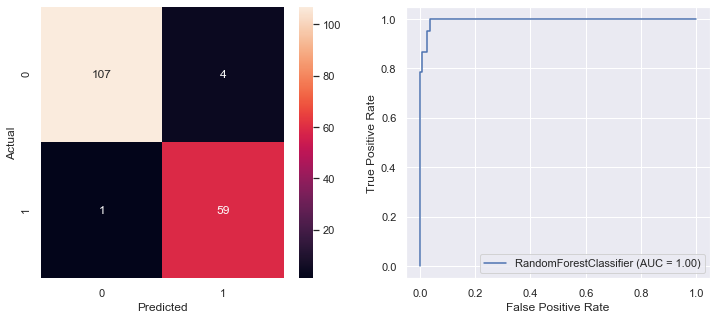

In [426]:
fig, axs = plt.subplots(ncols = 2, figsize=(12, 5))

confusion_matrix = pd.crosstab(y_test, tuner.best_estimator_.predict(X_test_scaled), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot = True, cmap = None, fmt='.0f', ax = axs[0])

plot_roc_curve(tuner.best_estimator_, X_test_scaled, y_test, ax = axs[1])

fig.tight_layout()
plt.show()

##### Find optimal threshold to avoid False Negatives (predicted healthy, actually sick)

In [430]:
confusion_matrix(y_test, tuner.best_estimator_.predict(X_test_scaled))

array([[107,   4],
       [  1,  59]], dtype=int64)

In [461]:
for i in np.arange(0, 1, 0.05):
    threshold = i
    predicted_probabilities = tuner.best_estimator_.predict_proba(X_test_scaled)[:,1]
    predicted_classes = np.where(predicted_probabilities > threshold, 1, 0)
    print(i, '\n', confusion_matrix(y_test, predicted_classes))

0.0 
 [[26 85]
 [ 0 60]]
0.05 
 [[96 15]
 [ 0 60]]
0.1 
 [[101  10]
 [  0  60]]
0.15000000000000002 
 [[105   6]
 [  0  60]]
0.2 
 [[106   5]
 [  0  60]]
0.25 
 [[106   5]
 [  0  60]]
0.30000000000000004 
 [[106   5]
 [  0  60]]
0.35000000000000003 
 [[106   5]
 [  0  60]]
0.4 
 [[107   4]
 [  0  60]]
0.45 
 [[107   4]
 [  0  60]]
0.5 
 [[107   4]
 [  1  59]]
0.55 
 [[107   4]
 [  2  58]]
0.6000000000000001 
 [[108   3]
 [  4  56]]
0.65 
 [[108   3]
 [  6  54]]
0.7000000000000001 
 [[108   3]
 [  7  53]]
0.75 
 [[108   3]
 [  7  53]]
0.8 
 [[110   1]
 [  8  52]]
0.8500000000000001 
 [[110   1]
 [ 11  49]]
0.9 
 [[111   0]
 [ 15  45]]
0.9500000000000001 
 [[111   0]
 [ 25  35]]


In [459]:
for i in np.arange(0, 1, 0.01):
    threshold = i
    predicted_probabilities = logit.predict_proba(X_test_scaled)[:,1]
    predicted_classes = np.where(predicted_probabilities > threshold, 1, 0)
    print(i, '\n', confusion_matrix(y_test, predicted_classes))

0.0 
 [[  0 111]
 [  0  60]]
0.01 
 [[84 27]
 [ 0 60]]
0.02 
 [[98 13]
 [ 0 60]]
0.03 
 [[104   7]
 [  0  60]]
0.04 
 [[105   6]
 [  0  60]]
0.05 
 [[106   5]
 [  0  60]]
0.06 
 [[106   5]
 [  0  60]]
0.07 
 [[106   5]
 [  1  59]]
0.08 
 [[106   5]
 [  1  59]]
0.09 
 [[106   5]
 [  1  59]]
0.1 
 [[106   5]
 [  1  59]]
0.11 
 [[106   5]
 [  1  59]]
0.12 
 [[106   5]
 [  1  59]]
0.13 
 [[106   5]
 [  1  59]]
0.14 
 [[106   5]
 [  1  59]]
0.15 
 [[106   5]
 [  1  59]]
0.16 
 [[106   5]
 [  1  59]]
0.17 
 [[106   5]
 [  1  59]]
0.18 
 [[106   5]
 [  1  59]]
0.19 
 [[106   5]
 [  1  59]]
0.2 
 [[106   5]
 [  1  59]]
0.21 
 [[106   5]
 [  2  58]]
0.22 
 [[106   5]
 [  3  57]]
0.23 
 [[106   5]
 [  3  57]]
0.24 
 [[106   5]
 [  3  57]]
0.25 
 [[106   5]
 [  3  57]]
0.26 
 [[106   5]
 [  3  57]]
0.27 
 [[106   5]
 [  3  57]]
0.28 
 [[106   5]
 [  3  57]]
0.29 
 [[106   5]
 [  3  57]]
0.3 
 [[107   4]
 [  3  57]]
0.31 
 [[107   4]
 [  3  57]]
0.32 
 [[107   4]
 [  3  57]]
0.33 
 [[107   4]
 [  

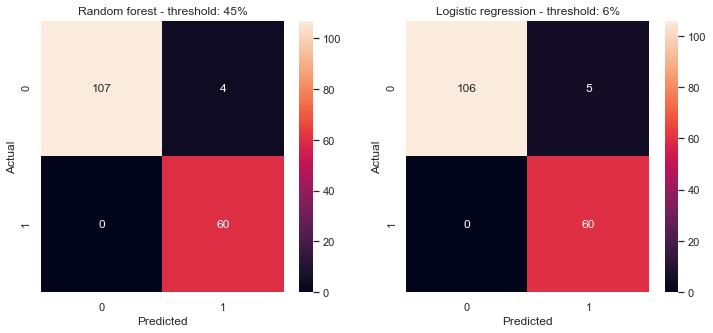

In [462]:
fig, axs = plt.subplots(ncols = 2, figsize=(12, 5))

threshold = 0.45
predicted_probabilities = tuner.best_estimator_.predict_proba(X_test_scaled)[:,1]
predicted_classes = np.where(predicted_probabilities > threshold, 1, 0)

confusion_matrix = pd.crosstab(y_test, predicted_classes, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot = True, cmap = None, fmt='.0f', ax = axs[0]).set_title('Random forest - threshold: 45%')

threshold = 0.06
predicted_probabilities = logit.predict_proba(X_test_scaled)[:,1]
predicted_classes = np.where(predicted_probabilities > threshold, 1, 0)

confusion_matrix = pd.crosstab(y_test, predicted_classes, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot = True, cmap = None, fmt='.0f', ax = axs[1]).set_title('Logistic regression - threshold: 6%')

plt.show()